In [2]:
import cupy as cp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

Play on a grid, show in pygame

# Class Init

In [33]:
# Constants
global width
width = 256
global height
height = 256
global fps
fps =  30

global p_settle, competition, p_mobility
p,z,q = 20,0,50 # Determine transition probabities where p is dominance, z is dominance + settlement, q is settlement
gamma = 50 #role switching probability
#mobility constant is 2*gamma/N wheere N is height*width AKA system size
#Probabilities of settlement, competition, etc determined with p,z,q above
competition = p/(p+q+gamma+z)
dominance = z/(p+q+gamma+z)
settlement = q/(p+q+gamma+z)
mobility = gamma/(p+q+gamma+z)

print(f"mobility is {mobility}")

print(f"the MODIFIED mobility constant of our game is {1/-cp.log(mobility)}")

# Transition probabilities - we should investigate parameters of this and relevant bifurcations
p_settle = settlement # Probability and grid member invades an empty square
p_rock_dominates = p_paper_dominates = p_scissors_dominates = competition
p_mobility = mobility





mobility is 0.4166666666666667
the MODIFIED mobility constant of our game is 1.1422452422715805


maybe get different evolution rule depending on neighbors??

## Class Initialization

In [4]:
class RockPaperScissors_new():
  '''
  Updated transition rules - now neighbor-number-sensitive
  '''
  # build grid
  def __init__(self):
    self.grid = cp.zeros((width, height), dtype=cp.int32) # Specify dtype
    self.species = [1,2,3] #How many species do we want in our system?
    self.counts = [0 for i in range(len(self.species))] # Array of population counts, for statistics later
    self.history = [] # Initialize history list
    self.density = 0.1 #change for different density initialization

  #Assign rock->1, paper->2, scissors->3
  #Thus 3 > 2 > 1 > 3 > ...

  def seeding(self):
    ''' Get starting positions of our grid '''
    density = self.density
    # Sample values for the entire grid
    values = cp.random.choice([1, 2, 3], size=(width, height), p=[1/3, 1/3, 1/3]).astype(cp.int32) # Specify dtype
    toggles = cp.random.choice([True, False], size=(width, height), p=[density, 1-density])
    # Update the grid where toggle is True
    self.grid = cp.where(toggles, values, 0) # Apply values only where toggles is True

    # Count the number of each species after seeding
    for i, species_type in enumerate(self.species):
        self.counts[i] = cp.sum(self.grid == species_type)

  def get_entropy(self):
    '''
    Calculates the 'border complexity' or entropy of the system using CuPy broadcasting.
    This involves calculating global species proportions, constructing a lookup table for
    relation probabilities (q_values), and then computing the entropic contribution
    for all cell-neighbor pairs in parallel.
    '''
    global settlement, competition # Access global probability constants

    current_grid = self.grid
    current_height, current_width = current_grid.shape
    total_cells = current_grid.size

    # Calculate global species proportions (p(x))
    species_proportions = cp.zeros(4, dtype=cp.float32)
    species_proportions[0] = cp.sum(current_grid == 0) / total_cells # Empty cells
    species_proportions[1] = cp.sum(current_grid == 1) / total_cells # Rock
    species_proportions[2] = cp.sum(current_grid == 2) / total_cells # Paper
    species_proportions[3] = cp.sum(current_grid == 3) / total_cells # Scissors

    #Construct the q_lookup_table_log - efficient way to get q(x,y) contributions
    # Initialize with default competition log value for non-empty, different species interaction
    # this gives the minimal number of changes to our matrix
    q_lookup_table_log = cp.full((4, 4), cp.log2(1 - competition), dtype=cp.float32)

    #Set same species or both empty (t, t) to log2(1) = 0
    for t in range(4):
        q_lookup_table_log[t, t] = cp.log2(1.0)

    #Set empty cell (0, t) with non-empty neighbor to log2(1 - settlement)
    for t in [1, 2, 3]:
        q_lookup_table_log[0, t] = cp.log2(1 - settlement)

    #Set non-empty cell (t, 0) with empty neighbor to log2(1 - settlement)
    for t in [1, 2, 3]:
        q_lookup_table_log[t, 0] = cp.log2(1 - settlement)

    #Prepare current_grid and neighbors
    padded_grid = cp.pad(current_grid, 1, mode='wrap') # Use wrap to handle toroidal grid

    neighbors = cp.zeros((8, current_height, current_width), dtype=cp.int32)
    neighbors[0] = padded_grid[:-2, :-2] # Top-left
    neighbors[1] = padded_grid[:-2, 1:-1] # Top-center
    neighbors[2] = padded_grid[:-2, 2:]   # Top-right
    neighbors[3] = padded_grid[1:-1, :-2] # Middle-left
    neighbors[4] = padded_grid[1:-1, 2:]   # Middle-right
    neighbors[5] = padded_grid[2:, :-2]   # Bottom-left
    neighbors[6] = padded_grid[2:, 1:-1] # Bottom-center
    neighbors[7] = padded_grid[2:, 2:]   # Bottom-right

    #Compute entropic contribution using broadcasting
    current_grid_reshaped = current_grid[cp.newaxis, :, :]

    #Look up the cp.log2(q(x,y)) values for all cell-neighbor pairs
    log_q_values = q_lookup_table_log[current_grid_reshaped, neighbors]

    #Calculate the weight_grid_values for each cell based on its species type
    #species_proportions is 1D (length 4), current_grid is 2D (height x width)
    #This uses advanced indexing to map each cell's type to its proportion
    weight_grid_values = species_proportions[current_grid]

    #Compute the entropic contribution for each cell-neighbor pair
    #Reshape weight_grid_values for broadcasting with log_q_values (8, height, width)
    entropic_contributions = (1/8) * weight_grid_values[cp.newaxis, :, :] * log_q_values

    #Sum these contributions
    total_entropy = -cp.sum(entropic_contributions)

    #Apply the scaling factor
    scaled_total_entropy = total_entropy / cp.sqrt(current_height * current_width)#2D -> 1D

    #Return the final total_entropy
    return scaled_total_entropy



  def update(self, counting=False):
    '''
    Markov process where we update our grid based on starting probabilities.
    Integrates settlement, domination, and mobility as concurrent, mutually exclusive actions.
    Dominated cells become empty, mobility involves swapping with a neighbor.
    '''
    global p_settle, competition, p_mobility # Access global probability constants

    current_grid = self.grid
    current_height, current_width = current_grid.shape

    # Initialize new_grid with the current_grid state.
    # Cells not affected by any rule will retain their state.
    new_grid = cp.copy(current_grid)

    # 1. Pad the grid to handle neighbors at edges (for neighbor calculations)
    padded_grid = cp.pad(current_grid, 1, mode='wrap') # Use wrap to handle toroidal grid

    # 2. Get neighbor values for each cell in the current_grid
    #We store as an 8-depth 3D tensor so each cell has its neighbor dynamics easily caluclated!
    neighbors = cp.zeros((8, current_height, current_width), dtype=cp.int32)
    neighbors[0] = padded_grid[:-2, :-2] # Top-left
    neighbors[1] = padded_grid[:-2, 1:-1] # Top-center
    neighbors[2] = padded_grid[:-2, 2:]   # Top-right
    neighbors[3] = padded_grid[1:-1, :-2] # Middle-left
    neighbors[4] = padded_grid[1:-1, 2:]   # Middle-right
    neighbors[5] = padded_grid[2:, :-2]   # Bottom-left
    neighbors[6] = padded_grid[2:, 1:-1] # Bottom-center
    neighbors[7] = padded_grid[2:, 2:]   # Bottom-right

    # Count non-empty neighbors and neighbors of each type for each cell
    non_empty_neighbor_count = cp.sum(neighbors != 0, axis=0)
    rock_neighbor_counts = cp.sum(neighbors == 1, axis=0)
    paper_neighbor_counts = cp.sum(neighbors == 2, axis=0)
    scissors_neighbor_counts = cp.sum(neighbors == 3, axis=0)

    # 3. Generate independent random rolls for each action type
    rand_settle_roll = cp.random.rand(current_height, current_width)
    rand_dominate_roll = cp.random.rand(current_height, current_width)
    rand_mobility_roll = cp.random.rand(current_height, current_width)

    # 4. Calculate local probabilities for each action

    # Settlement probability (prob_settle_local)
    prob_settle_local = 1 - (1 - p_settle)**non_empty_neighbor_count
    # Ensure prob_settle_local is 0 where non_empty_neighbor_count is 0 (or where cell is not empty)
    prob_settle_local = cp.where(non_empty_neighbor_count == 0, 0.0, prob_settle_local)

    # Domination probability (prob_dominate_local)
    prob_dominate_local = cp.zeros((current_height, current_width), dtype=cp.float32)

    # Rock (1) dominated by Paper (2)
    rock_cells = (current_grid == 1)
    prob_dominate_local = cp.where(rock_cells, 1 - (1 - competition)**paper_neighbor_counts, prob_dominate_local)

    # Paper (2) dominated by Scissors (3)
    paper_cells = (current_grid == 2)
    prob_dominate_local = cp.where(paper_cells, 1 - (1 - competition)**scissors_neighbor_counts, prob_dominate_local)

    # Scissors (3) dominated by Rock (1)
    scissors_cells = (current_grid == 3)
    prob_dominate_local = cp.where(scissors_cells, 1 - (1 - competition)**rock_neighbor_counts, prob_dominate_local)

    # Mobility probability (prob_mobility_local)
    # Assuming max 8 neighbors for mobility consideration (Moore neighborhood)
    prob_mobility_local = 1 - (1 - p_mobility)**8
    # Only occupied cells can move
    prob_mobility_local = cp.where(current_grid == 0, 0.0, prob_mobility_local)

    # 5. Create masks for each action based on independent rolls and local probabilities, ensuring priority.
    # Priority: Settlement > Domination > Mobility

    # ----------------------- Settlement Mask ------------------------
    # Cells that roll for settlement AND are empty AND have non-empty neighbors.
    final_settle_mask = (current_grid == 0) & (rand_settle_roll < prob_settle_local)

    # ----------------------- Domination Mask ------------------------
    # Cells that roll for domination AND are occupied AND meet domination conditions
    # AND are not already settling.
    domination_condition_mask = \
        ((current_grid == 1) & (paper_neighbor_counts > 0)) | \
        ((current_grid == 2) & (scissors_neighbor_counts > 0)) | \
        ((current_grid == 3) & (rock_neighbor_counts > 0))

    final_dominate_mask = \
        (~final_settle_mask) & \
        (current_grid != 0) & \
        (rand_dominate_roll < prob_dominate_local) & \
        domination_condition_mask


    # ------------------------- Mobility Mask --------------------------
    # Cells that roll for mobility AND are occupied AND are not settling or dominating.
    mobility_condition_mask = (current_grid != 0)
    final_mobility_mask = \
        (~final_settle_mask) & \
        (~final_dominate_mask) & \
        (rand_mobility_roll < prob_mobility_local) & \
        mobility_condition_mask


    # 6. Apply actions to new_grid based on the final, mutually exclusive masks.

    # Apply Settlement: Empty cells adopt a random non-empty neighbor's species
    if cp.any(final_settle_mask):
        settling_y_coords, settling_x_coords = cp.where(final_settle_mask)
        num_settling_cells = settling_y_coords.shape[0]

        if num_settling_cells > 0:
            # For each settling cell, choose a random neighbor index (0-7)
            rand_neighbor_idx_for_settlers = cp.random.randint(0, 8, size=num_settling_cells)

            # Get the species of these randomly chosen neighbors
            # `neighbors[k, y, x]` gives the k-th neighbor's species for cell (y,x)
            chosen_neighbor_species = neighbors[rand_neighbor_idx_for_settlers, settling_y_coords, settling_x_coords]

            # Only settle if the chosen neighbor is not empty (species != 0)
            valid_settlement_mask_for_chosen_neighbor = (chosen_neighbor_species != 0)

            # Apply the species of the valid chosen neighbors to the new_grid
            new_grid[settling_y_coords[valid_settlement_mask_for_chosen_neighbor],
                     settling_x_coords[valid_settlement_mask_for_chosen_neighbor]] = \
                chosen_neighbor_species[valid_settlement_mask_for_chosen_neighbor]

    # Apply Domination: Dominated cells become empty (0)
    if cp.any(final_dominate_mask):
        new_grid[final_dominate_mask] = 0

    # Apply Mobility: Occupied cells swap their state with a randomly chosen neighbor
    mover_y, mover_x = cp.where(final_mobility_mask)
    num_movers = mover_y.shape[0]

    if num_movers > 0:
        # Select a random neighbor for each mover (index 0-7 for 8 neighbors)
        rand_neighbor_idx = cp.random.randint(0, 8, size=num_movers)

        # Define offsets for 8 neighbors (Moore neighborhood)
        offsets_y = cp.array([-1, -1, -1, 0, 0, 1, 1, 1], dtype=cp.int32)
        offsets_x = cp.array([-1, 0, 1, -1, 1, -1, 0, 1], dtype=cp.int32)

        # Calculate target coordinates for each mover, ensuring wrap-around boundaries
        target_y = (mover_y + offsets_y[rand_neighbor_idx]) % current_height
        target_x = (mover_x + offsets_x[rand_neighbor_idx]) % current_width

        # To perform the swap in parallel without race conditions or overwriting intermediate values:
        # We need to read values from `current_grid` (the state *before* any updates this tick)
        # and write them to appropriate locations in `new_grid`.

        # Get the current values at the mover's original position and their target neighbor's position
        values_at_mover_positions = current_grid[mover_y, mover_x]
        values_at_target_positions = current_grid[target_y, target_x]

        # Assign the target neighbor's value to the mover's original position in new_grid
        new_grid[mover_y, mover_x] = values_at_target_positions

        # Assign the mover's original value to the target neighbor's position in new_grid
        # Note: If multiple movers target the same cell, the last write will prevails.
        # This is generally acceptable for this type of simulation as order is not strictly critical.
        new_grid[target_y, target_x] = values_at_mover_positions

    self.grid = new_grid # Update the grid to the new state

    # Update counts if counting is enabled
    if counting:
      for i, species_type in enumerate(self.species):
          self.counts[i] = cp.sum(self.grid == species_type)
      self.history.append([count.get().item() for count in self.counts]) # Add counts to history (transfer to CPU for plotting)

    return self.grid

In [ ]:
class RockPaperScissors():
  '''
  RPS class - doesn't have neighbor-number-sensitive rules
  '''

  # build grid
  def __init__(self):
    self.grid = cp.zeros((width, height), dtype=cp.int32) # Specify dtype
    self.species = [1,2,3] #How many species do we want in our system?
    self.counts = [0 for i in range(len(self.species))] # Array of population counts, for statistics later
    self.history = [] # Initialize history list
    self.density = 0.1 #change for different density initialization

  #Assign rock->1, paper->2, scissors->3
  #Thus 3 > 2 > 1 > 3 > ...

  def seeding(self):
    ''' Get starting positions of our grid '''
    density = self.density
    # Sample values for the entire grid
    values = cp.random.choice([1, 2, 3], size=(width, height), p=[1/3, 1/3, 1/3]).astype(cp.int32) # Specify dtype
    toggles = cp.random.choice([True, False], size=(width, height), p=[density, 1-density])
    # Update the grid where toggle is True
    self.grid = cp.where(toggles, values, 0) # Apply values only where toggles is True

    # Count the number of each species after seeding
    for i, species_type in enumerate(self.species):
        self.counts[i] = cp.sum(self.grid == species_type)

  def get_entropy(self):
    '''
    Calculates the 'border complexity' or entropy of the system using CuPy broadcasting.
    This involves calculating global species proportions, constructing a lookup table for
    relation probabilities (q_values), and then computing the entropic contribution
    for all cell-neighbor pairs in parallel.
    '''
    global settlement, competition # Access global probability constants

    current_grid = self.grid
    current_height, current_width = current_grid.shape
    total_cells = current_grid.size

    # Calculate global species proportions (p(x))
    species_proportions = cp.zeros(4, dtype=cp.float32)
    species_proportions[0] = cp.sum(current_grid == 0) / total_cells # Empty cells
    species_proportions[1] = cp.sum(current_grid == 1) / total_cells # Rock
    species_proportions[2] = cp.sum(current_grid == 2) / total_cells # Paper
    species_proportions[3] = cp.sum(current_grid == 3) / total_cells # Scissors

    #Construct the q_lookup_table_log - efficient way to get q(x,y) contributions
    # Initialize with default competition log value for non-empty, different species interaction
    # this gives the minimal number of changes to our matrix
    q_lookup_table_log = cp.full((4, 4), cp.log2(1 - competition), dtype=cp.float32)

    #Set same species or both empty (t, t) to log2(1) = 0
    for t in range(4):
        q_lookup_table_log[t, t] = cp.log2(1.0)

    #Set empty cell (0, t) with non-empty neighbor to log2(1 - settlement)
    for t in [1, 2, 3]:
        q_lookup_table_log[0, t] = cp.log2(1 - settlement)

    #Set non-empty cell (t, 0) with empty neighbor to log2(1 - settlement)
    for t in [1, 2, 3]:
        q_lookup_table_log[t, 0] = cp.log2(1 - settlement)

    #Prepare current_grid and neighbors
    padded_grid = cp.pad(current_grid, 1, mode='wrap') # Use wrap to handle toroidal grid

    neighbors = cp.zeros((8, current_height, current_width), dtype=cp.int32)
    neighbors[0] = padded_grid[:-2, :-2] # Top-left
    neighbors[1] = padded_grid[:-2, 1:-1] # Top-center
    neighbors[2] = padded_grid[:-2, 2:]   # Top-right
    neighbors[3] = padded_grid[1:-1, :-2] # Middle-left
    neighbors[4] = padded_grid[1:-1, 2:]   # Middle-right
    neighbors[5] = padded_grid[2:, :-2]   # Bottom-left
    neighbors[6] = padded_grid[2:, 1:-1] # Bottom-center
    neighbors[7] = padded_grid[2:, 2:]   # Bottom-right

    #Compute entropic contribution using broadcasting
    current_grid_reshaped = current_grid[cp.newaxis, :, :]

    #Look up the cp.log2(q(x,y)) values for all cell-neighbor pairs
    log_q_values = q_lookup_table_log[current_grid_reshaped, neighbors]

    #Calculate the weight_grid_values for each cell based on its species type
    #species_proportions is 1D (length 4), current_grid is 2D (height x width)
    #This uses advanced indexing to map each cell's type to its proportion
    weight_grid_values = species_proportions[current_grid]

    #Compute the entropic contribution for each cell-neighbor pair
    #Reshape weight_grid_values for broadcasting with log_q_values (8, height, width)
    entropic_contributions = (1/8) * weight_grid_values[cp.newaxis, :, :] * log_q_values

    #Sum these contributions
    total_entropy = -cp.sum(entropic_contributions)

    #Apply the scaling factor
    scaled_total_entropy = total_entropy / cp.sqrt(current_height * current_width)#2D -> 1D

    #Return the final total_entropy
    return scaled_total_entropy



  def update(self, counting=False):
    '''
    Markov process where we update our grid based on starting probabilities.
    Integrates settlement, domination, and mobility as concurrent, mutually exclusive actions.
    Dominated cells become empty, mobility involves swapping with a neighbor.
    '''
    global p_settle, competition, mobility # Access global probability constants

    current_grid = self.grid
    current_height, current_width = current_grid.shape

    # Initialize new_grid with the current_grid state.
    # Cells not affected by any rule will retain their state.
    new_grid = cp.copy(current_grid)

    # 1. Pad the grid to handle neighbors at edges (for neighbor calculations)
    padded_grid = cp.pad(current_grid, 1, mode='wrap') # Use wrap to handle toroidal grid

    # 2. Get neighbor values for each cell in the current_grid
    #We store as an 8-depth 3D tensor so each cell has its neighbor dynamics easily caluclated!
    neighbors = cp.zeros((8, current_height, current_width), dtype=cp.int32)
    neighbors[0] = padded_grid[:-2, :-2] # Top-left
    neighbors[1] = padded_grid[:-2, 1:-1] # Top-center
    neighbors[2] = padded_grid[:-2, 2:]   # Top-right
    neighbors[3] = padded_grid[1:-1, :-2] # Middle-left
    neighbors[4] = padded_grid[1:-1, 2:]   # Middle-right
    neighbors[5] = padded_grid[2:, :-2]   # Bottom-left
    neighbors[6] = padded_grid[2:, 1:-1] # Bottom-center
    neighbors[7] = padded_grid[2:, 2:]   # Bottom-right

    # Count non-empty neighbors and neighbors of each type for each cell
    non_empty_neighbor_count = cp.sum(neighbors != 0, axis=0)
    rock_neighbor_counts = cp.sum(neighbors == 1, axis=0)
    paper_neighbor_counts = cp.sum(neighbors == 2, axis=0)
    scissors_neighbor_counts = cp.sum(neighbors == 3, axis=0)

    # 3. Generate a single random decision for each cell
    rand_decision = cp.random.rand(current_height, current_width)

    # 4. Define cumulative probability thresholds for mutually exclusive actions
    # These thresholds define the 'ranges' for each action based on rand_decision.
    # uniform distribution....
    settle_threshold = p_settle
    compete_threshold = p_settle + competition # 'competition' is the global probability for competitive domination
    mobility_threshold = p_settle + competition + p_mobility # 'p_mobility' is the global mobility probability

    # 5. Create masks for each action based on random decision AND environmental conditions.
    # These masks ensure actions are mutually exclusive for each cell based on its rand_decision.

    # ----------------------- Settlement Mask ------------------------
    # Cells that roll for settlement AND are empty AND have non-empty neighbors.
    settling_candidates_mask = (current_grid == 0) & (non_empty_neighbor_count > 1)
    final_settle_mask = (rand_decision < settle_threshold) & settling_candidates_mask

    # ----------------------- Domination Mask ------------------------
    # Cells that roll for domination AND are occupied AND meet domination conditions.
    # Domination conditions: Rock (1) dominated by Paper (2), Paper (2) by Scissors (3), Scissors (3) by Rock (1)
    rock_is_dominated = (current_grid == 1) & (paper_neighbor_counts > 1)
    paper_is_dominated = (current_grid == 2) & (scissors_neighbor_counts > 1)
    scissors_is_dominated = (current_grid == 3) & (rock_neighbor_counts > 1)
    domination_condition_mask = rock_is_dominated | paper_is_dominated | scissors_is_dominated
    # Ensure this action is mutually exclusive with settlement
    final_dominate_mask = ((rand_decision >= settle_threshold) & (rand_decision < compete_threshold)) & domination_condition_mask & ~final_settle_mask

    # ------------------------- Mobility Mask --------------------------
    # Cells that roll for mobility AND are occupied.
    mobility_condition_mask = (current_grid != 0)
    # Ensure this action is mutually exclusive with settlement and domination
    final_mobility_mask = ((rand_decision >= compete_threshold) & (rand_decision < mobility_threshold)) & mobility_condition_mask & ~final_settle_mask & ~final_dominate_mask


    # 6. Apply actions to new_grid based on the final, mutually exclusive masks.
    # Note: Actions are applied in sequence to new_grid, but because masks are mutually exclusive,
    # a cell's state is only determined by one action type.

    # Apply Settlement: Empty cells adopt a random non-empty neighbor's species
    if cp.any(final_settle_mask):
        settling_y_coords, settling_x_coords = cp.where(final_settle_mask)
        num_settling_cells = settling_y_coords.shape[0]

        if num_settling_cells > 0:
            # For each settling cell, choose a random neighbor index (0-7)
            rand_neighbor_idx_for_settlers = cp.random.randint(0, 8, size=num_settling_cells)

            # Get the species of these randomly chosen neighbors
            # `neighbors[k, y, x]` gives the k-th neighbor's species for cell (y,x)
            chosen_neighbor_species = neighbors[rand_neighbor_idx_for_settlers, settling_y_coords, settling_x_coords]

            # Only settle if the chosen neighbor is not empty (species != 0)
            valid_settlement_mask_for_chosen_neighbor = (chosen_neighbor_species != 0)

            # Apply the species of the valid chosen neighbors to the new_grid
            new_grid[settling_y_coords[valid_settlement_mask_for_chosen_neighbor],
                     settling_x_coords[valid_settlement_mask_for_chosen_neighbor]] = \
                chosen_neighbor_species[valid_settlement_mask_for_chosen_neighbor]

    # Apply Domination: Dominated cells become empty (0)
    if cp.any(final_dominate_mask):
        new_grid[final_dominate_mask] = 0

    # Apply Mobility: Occupied cells swap their state with a randomly chosen neighbor
    mover_y, mover_x = cp.where(final_mobility_mask)
    num_movers = mover_y.shape[0]

    if num_movers > 0:
        # Select a random neighbor for each mover (index 0-7 for 8 neighbors)
        rand_neighbor_idx = cp.random.randint(0, 8, size=num_movers)

        # Define offsets for 8 neighbors (Moore neighborhood)
        offsets_y = cp.array([-1, -1, -1, 0, 0, 1, 1, 1], dtype=cp.int32)
        offsets_x = cp.array([-1, 0, 1, -1, 1, -1, 0, 1], dtype=cp.int32)

        # Calculate target coordinates for each mover, ensuring wrap-around boundaries
        target_y = (mover_y + offsets_y[rand_neighbor_idx]) % current_height
        target_x = (mover_x + offsets_x[rand_neighbor_idx]) % current_width

        # To perform the swap in parallel without race conditions or overwriting intermediate values:
        # We need to read values from `current_grid` (the state *before* any updates this tick)
        # and write them to appropriate locations in `new_grid`.

        # Get the current values at the mover's original position and their target neighbor's position
        values_at_mover_positions = current_grid[mover_y, mover_x]
        values_at_target_positions = current_grid[target_y, target_x]

        # Assign the target neighbor's value to the mover's original position in new_grid
        new_grid[mover_y, mover_x] = values_at_target_positions

        # Assign the mover's original value to the target neighbor's position in new_grid
        # Note: If multiple movers target the same cell, the last write will prevails.
        # This is generally acceptable for this type of simulation as order is not strictly critical.
        new_grid[target_y, target_x] = values_at_mover_positions

    self.grid = new_grid # Update the grid to the new state

    # Update counts if counting is enabled
    if counting:
      for i, species_type in enumerate(self.species):
          self.counts[i] = cp.sum(self.grid == species_type)
      self.history.append([count.get().item() for count in self.counts]) # Add counts to history (transfer to CPU for plotting)

    return self.grid

# Plotting populations

## Visualize static frames

[array(5343), array(5293), array(5334)]


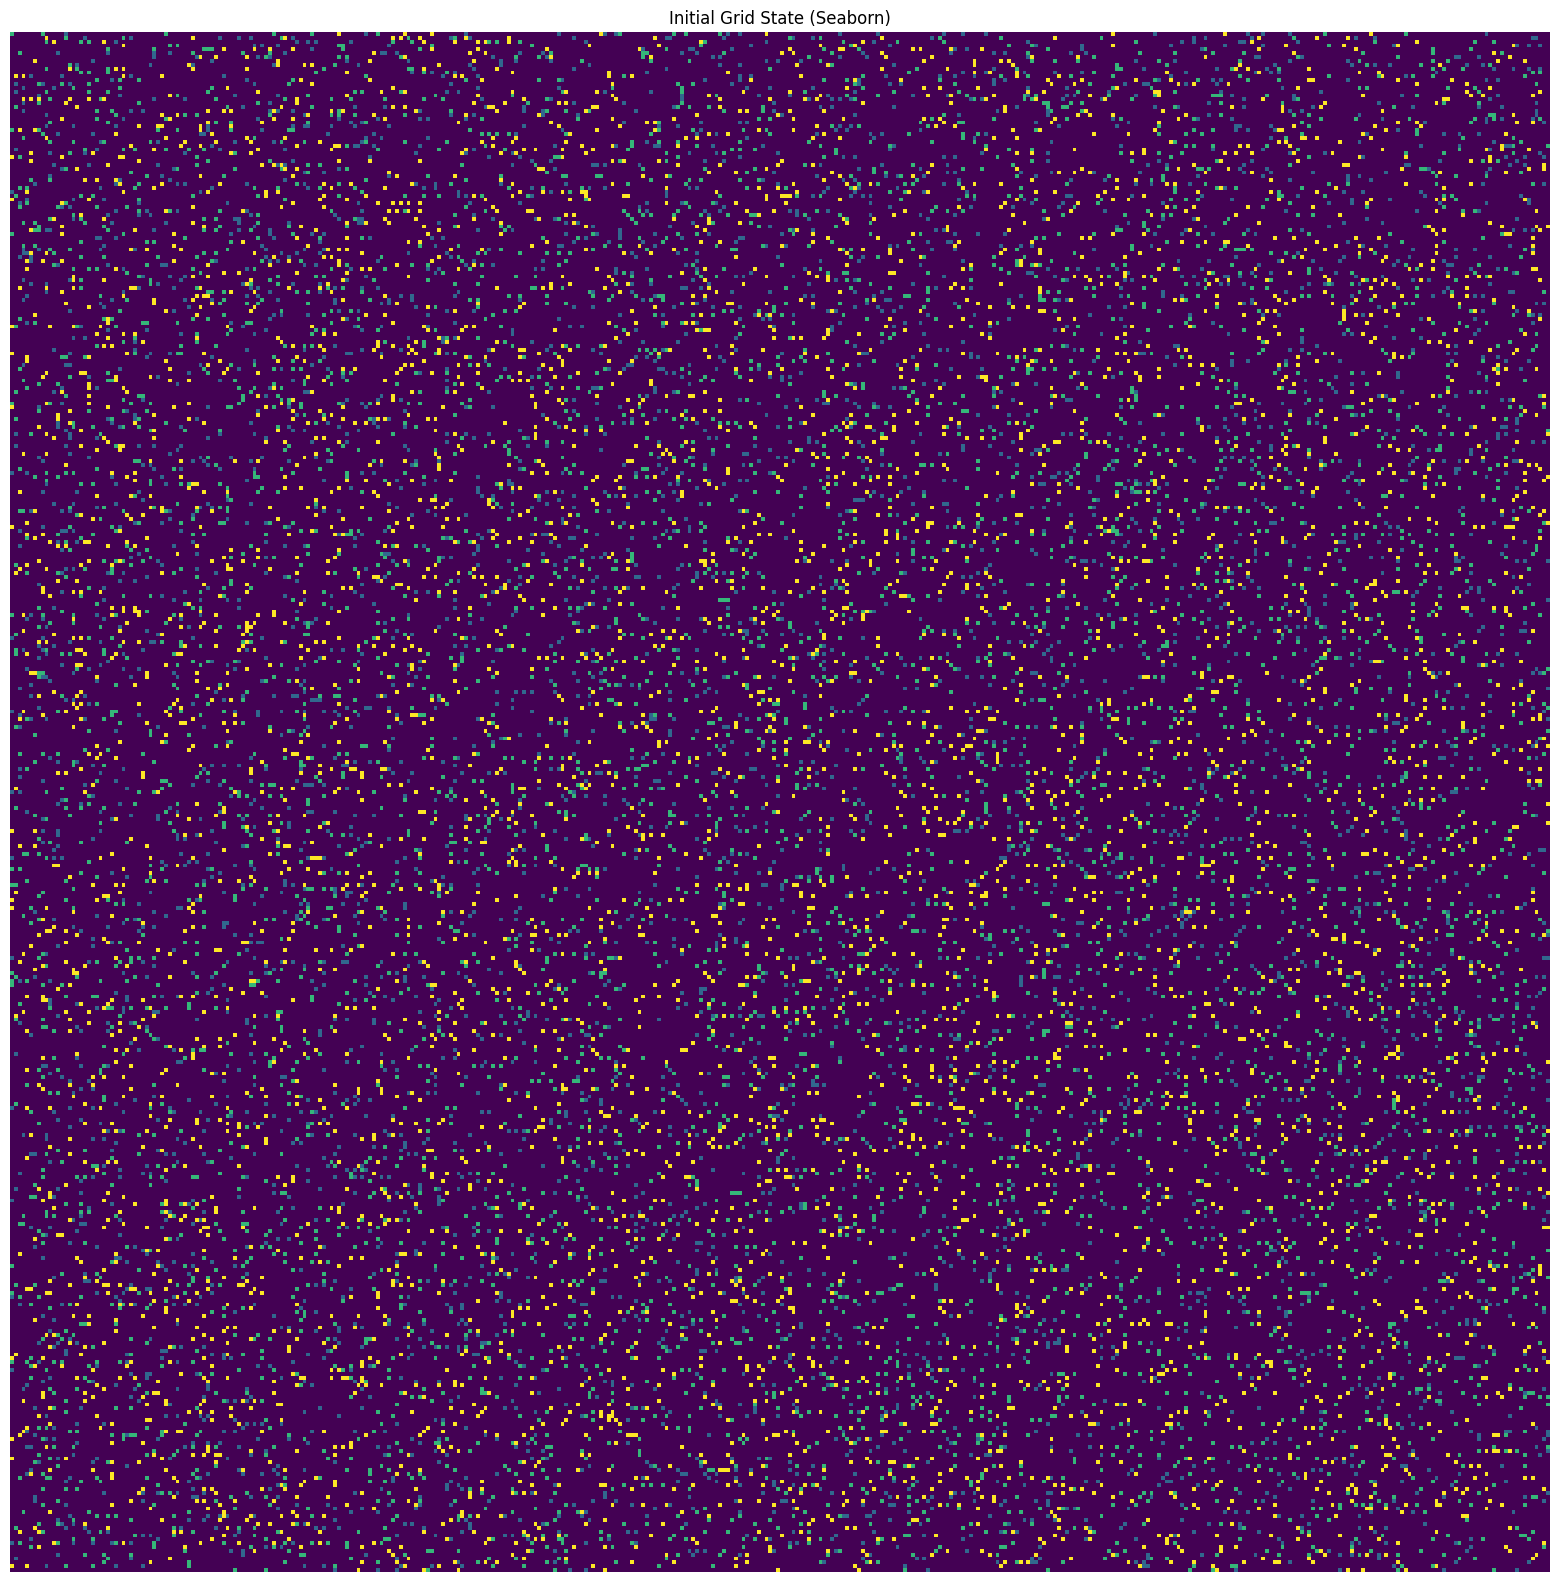

In [ ]:
import matplotlib.pyplot as plt
# hashtag
# Create an instance of the game
game = RockPaperScissors()
game.seeding()
#Print number of instances
print(game.counts)

# Convert the CuPy grid to a NumPy array
numpy_grid = cp.asnumpy(game.grid)

# Use Seaborn to create a heatmap
plt.figure(figsize=(width/20, height/20)) # Adjust figure size based on grid dimensions
sns.heatmap(numpy_grid, cmap="viridis", cbar=False, square=True)
plt.title("Initial Grid State (Seaborn)")
plt.axis('off') # Hide axes
plt.show()

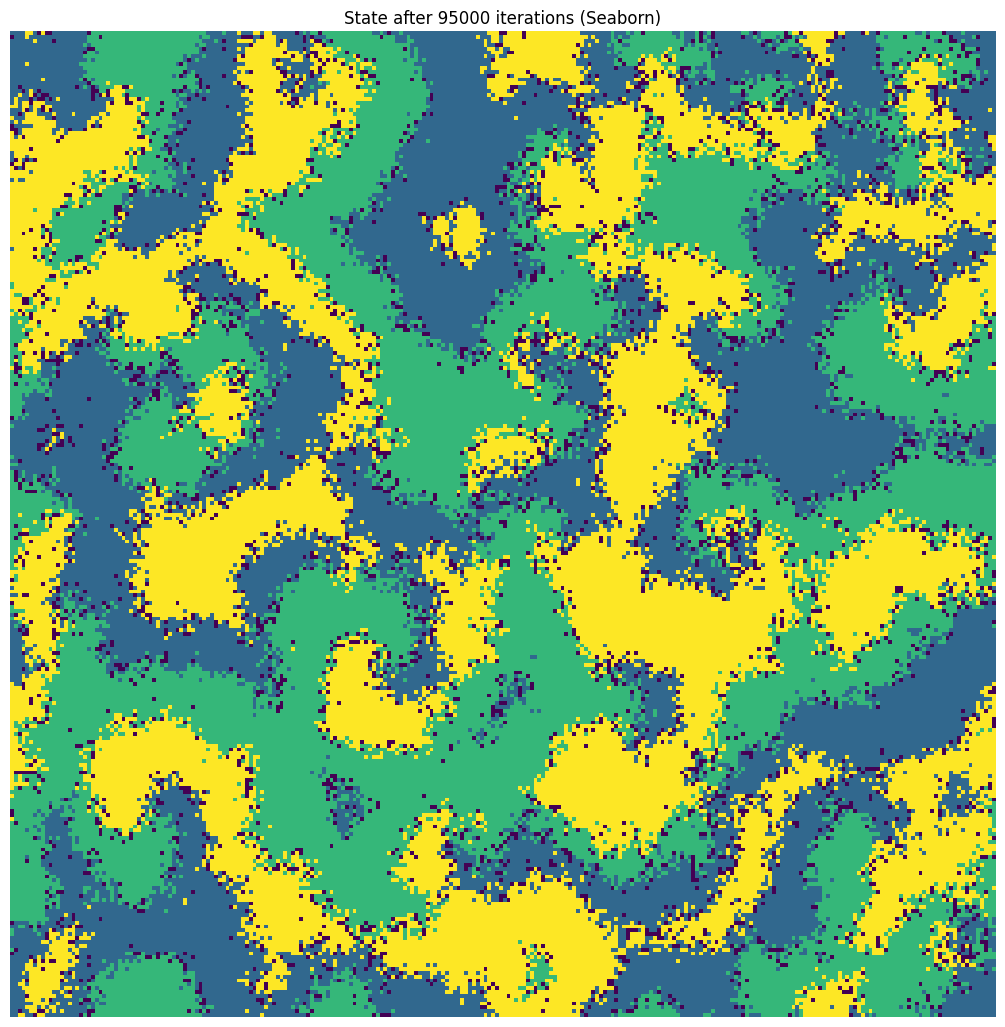

In [34]:
#Visualize a static frame after k iterations
game  = RockPaperScissors()
game.seeding()
epochs = 95000

for i in range(epochs):
  game.update()

numpy_grid = cp.asnumpy(game.grid)
# Use Seaborn to create a heatmap
plt.figure(figsize=(width/20, height/20)) # Adjust figure size based on grid dimensions
sns.heatmap(numpy_grid, cmap="viridis", cbar=False, square=True)
plt.title(f"State after {epochs} iterations (Seaborn)")
plt.axis('off') # Hide axes
plt.show()

## Static population plot (colab supported)

---



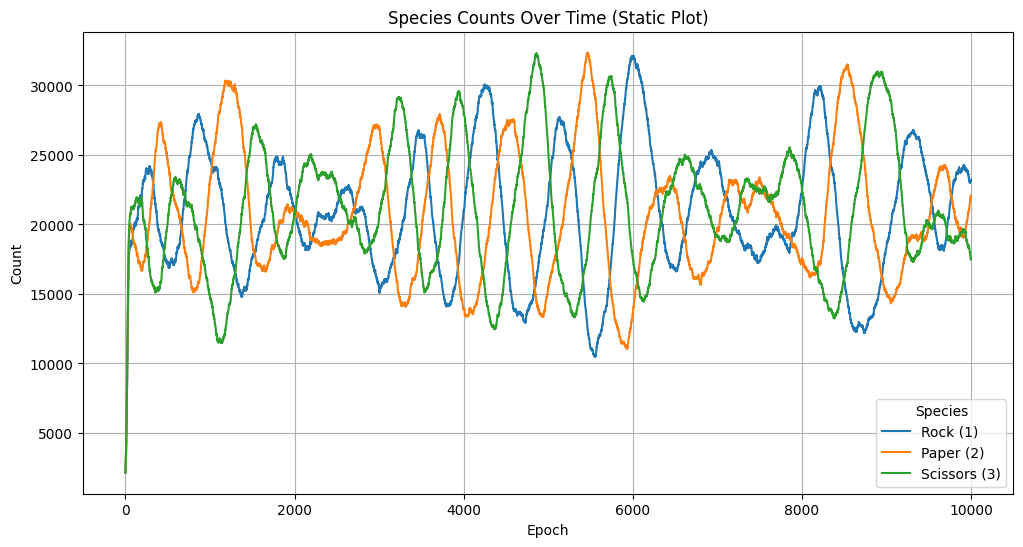

In [ ]:
from contextlib import nullcontext
#meow
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np # Import numpy


# Create an instance of the game and run a simulation to populate self.history
game_instance = None
gc.collect() #Collect garbage RAM
game_instance = RockPaperScissors()
epochs = 10000 # You can adjust the number of epochs for the static plot
game_instance.seeding()

# Append the initial counts after seeding to the history (transfer to CPU and convert to item)
initial_counts_cpu = [count.get().item() for count in game_instance.counts]
game_instance.history.append(initial_counts_cpu)

# Run the simulation with counting enabled to populate self.history
for epoch in range(epochs):
    game_instance.update(counting=True)

# Check if history was populated
if game_instance.history:
    # The history now contains lists of Python integers, no need for .get().item() again here
    # Convert the history data to a pandas DataFrame for plotting
    # Map the species numbers to strings for the 'Species' column
    species_map = {0: "Rock (1)", 1: "Paper (2)", 2: "Scissors (3)"}
    counts_df = pd.DataFrame(game_instance.history, columns=[species_map[i] for i in range(len(game_instance.species))])


    # Add an epoch number column
    counts_df['Epoch'] = range(len(counts_df))

    # Melt the DataFrame to a long format suitable for seaborn.lineplot
    counts_melted = counts_df.melt('Epoch', var_name='Species', value_name='Count')

    # Create the static seaborn line plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=counts_melted, x='Epoch', y='Count', hue='Species')

    plt.title("Species Counts Over Time (Static Plot)")
    plt.xlabel("Epoch")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()
else:
    print("game_instance.history is empty. Ensure the simulation was run with counting enabled.")

# Saving game states for dynamic visualization

## h5py and h5d data storage - use to get file for pygame visualization

In [31]:
!pip install h5py

Visualizing over epochs

In [32]:
# Create grid and initialize. Visualize in pygame, with different colors
epochs = 600 #Number of epochs

#Initialize
game = RockPaperScissors()
game.seeding()

# Create an HDF5 file to store the grids
import h5py
output_filename = 'simulation_grids.h5'

with h5py.File(output_filename, 'w') as f:
    for i in range(epochs):
        game.update()
        # Convert CuPy grid to NumPy array
        grid_np = cp.asnumpy(game.grid)
        # Create a dataset in the HDF5 file for the current epoch
        f.create_dataset(f'epoch_{i:05d}', data=grid_np)

print(f"Simulation finished. Saved {epochs} grid states to '{output_filename}'.")

Simulation finished. Saved 600 grid states to 'simulation_grids.h5'.


Skipping epochs for longer-range vision

In [ ]:
epochs = 20000 # Number of epochs
save_interval = 200 # Save every 1000 epochs

# Initialize
game = RockPaperScissors()
game.seeding()

# Create an HDF5 file to store the grids
import h5py
output_filename = 'simulation_grids.h5'

with h5py.File(output_filename, 'w') as f:
    for i in range(epochs):
        game.update()
        if i % save_interval == 0:
            # Convert CuPy grid to NumPy array
            grid_np = cp.asnumpy(game.grid)
            # Create a dataset in the HDF5 file for the current epoch
            f.create_dataset(f'epoch_{i:05d}', data=grid_np)

print(f"Simulation finished. Saved {epochs / save_interval} grid states to '{output_filename}' every {save_interval} epochs.")

Simulation finished. Saved 100.0 grid states to 'simulation_grids.h5' every 200 epochs.


In [ ]:
#Clear RAM cache of grids
import gc
gc.collect()



0

In [ ]:
# This code is intended to be run in a local Python environment with Pygame and h5py installed.
# It will not display a window in Google Colab.

import pygame
import numpy as np
import h5py # Import h5py
import time # Import time for potential delays

# Assuming width and height are defined globally or passed in
# If running this code separately, make sure width and height are defined.
# Example:
# width = 800
# height = 400
# fps = 30 # Also ensure fps is defined

# Define colors for the states (0: empty, 1: rock, 2: paper, 3: scissors)
BLACK = (0, 0, 0)       # Empty
RED = (255, 0, 0)       # Rock
GREEN = (0, 255, 0)     # Paper
BLUE = (0, 0, 255)      # Scissors

COLORS = {
    0: BLACK,
    1: RED,
    2: GREEN,
    3: BLUE
}

# Initialize Pygame
pygame.init()

# Set the dimensions of the window
screen_width = width
screen_height = height
screen = pygame.display.set_mode((screen_width, screen_height))

# Set the window title
pygame.display.set_caption("Rock Paper Scissors Simulation")

# Load the simulation log from the HDF5 file
simulation_grids = []
try:
    output_filename = 'simulation_grids.h5' # Define the filename
    with h5py.File(output_filename, 'r') as f:
        # Assuming datasets are named 'epoch_00000', 'epoch_00001', etc.
        # Get sorted list of epoch dataset names
        epoch_names = sorted([name for name in f.keys() if name.startswith('epoch_')])
        for name in epoch_names:
            grid_np = f[name][()] # Load the dataset as a NumPy array
            simulation_grids.append(grid_np)

    print(f"Successfully loaded {len(simulation_grids)} grid states from '{output_filename}'.")

except FileNotFoundError:
    print(f"Error: {output_filename} not found. Please run the simulation cell first.")
    simulation_grids = [] # Empty list if file not found
except Exception as e:
    print(f"Error loading data from HDF5 file: {e}")
    simulation_grids = []


# --- Drawing parameters ---
# Calculate cell size
cell_size_x = screen_width // width
cell_size_y = screen_height // height

# Main game loop
running = True
clock = pygame.time.Clock()
current_epoch_index = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    if simulation_grids and current_epoch_index < len(simulation_grids):
        current_grid = simulation_grids[current_epoch_index] # Corrected: Access the grid directly from the list

        # Clear the screen
        screen.fill(BLACK)

        # Draw the grid
        for y in range(height):
            for x in range(width):
                state = current_grid[y, x]
                color = COLORS.get(state, BLACK) # Default to black if state is unknown
                pygame.draw.rect(screen, color, (x * cell_size_x, y * cell_size_y, cell_size_x, cell_size_y))

        # Update the display
        pygame.display.flip()

        # Move to the next epoch
        current_epoch_index += 1

        # Control playback speed
        clock.tick(fps) # Use the fps constant defined earlier

    elif simulation_grids:
        # Stop or loop when simulation ends
        print("Simulation visualization finished.")
        running = False # Stop after the last frame

    else:
        # If no grids were loaded, exit
        running = False


# Quit Pygame
pygame.quit()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
Error: simulation_grids.h5 not found. Please run the simulation cell first.


# Entropy calculation
Change parameters to get different entropy amounts

In [24]:
#basic test
game = RockPaperScissors()
game.seeding()
for i in range(500):
  game.update()
entropy = game.get_entropy()
print(f"entropy is {entropy}")

entropy is 1.9327857494354248


testing entropy wrt parameter changes!
go through values of settlement, with others fixed, plot resulting state entropy against modified coefficients

In [ ]:
global p_settle, competition, p_mobility
p,q,gamma = 50,50,50
# Constants
global width
width = 512
global height
height = 512

#Loop through values of gamma as multiples of 5 from 0 -> 400
top, step = 400, 5
l = 5 # number of game-runs with given params, so we average over entropies
iterations = 1000 # enough for transient dynamics to stabilize
data = [] #Data array to store each entropy values, which itself is a an l-array of floats
mobility_coeffs = [] #Array to store each mobility value (simpler handling than dictionary)
for i in range(int(top/step)+1):
  gamma = i*step
  #Set probabilities
  competition = p/(p+q+gamma+z)
  dominance = z/(p+q+gamma+z)
  settlement = q/(p+q+gamma+z)
  mobility = gamma/(p+q+gamma+z)
  mobility_coeff = 1/-cp.log(mobility)
  print(f"mobility coefficient: {mobility_coeff}")

  # Transition probabilities
  p_settle = settlement # Probability and grid member invades an empty square
  p_rock_dominates = p_paper_dominates = p_scissors_dominates = competition
  p_mobility = mobility

  # array of logged entropy values
  cur_entropy_vals = []
  # Run the game l times each step, store entropy for each
  for j in range(5):
    game = RockPaperScissors()
    game.seeding()
    for k in range(iterations):
      game.update()
    cur_entropy_vals.append(game.get_entropy())
  mobility_coeffs.append(mobility_coeff)
  data.append(cur_entropy_vals)



mobility coefficient: 0.0
mobility coefficient: 0.3284587387530511
mobility coefficient: 0.4170323914242463
mobility coefficient: 0.4909464739297298
mobility coefficient: 0.5581106265512472
mobility coefficient: 0.6213349345596119
mobility coefficient: 0.6819714384107116
mobility coefficient: 0.7407809531024846
mobility coefficient: 0.798235600147928
mobility coefficient: 0.8546488068439961
mobility coefficient: 0.9102392266268373
mobility coefficient: 0.9651653192318395
mobility coefficient: 1.0195454478232662
mobility coefficient: 1.0734702305243111
mobility coefficient: 1.1270104803341574
mobility coefficient: 1.1802225011438285
mobility coefficient: 1.2331517311882159
mobility coefficient: 1.2858353163793146
mobility coefficient: 1.3383039694505456
mobility coefficient: 1.3905833398673346
mobility coefficient: 1.4426950408889634
mobility coefficient: 1.4946574315020966
mobility coefficient: 1.546486219947016
mobility coefficient: 1.598194935314681
mobility coefficient: 1.6497953001

create a table of averaged entropies for each mobility coefficient

In [ ]:
table = []
#Add (mobility coeff, averaged entropy, i) to table
for i in range(len(mobility_coeffs)):
    table.append((mobility_coeffs[i], cp.average(data[i]), i))


plot

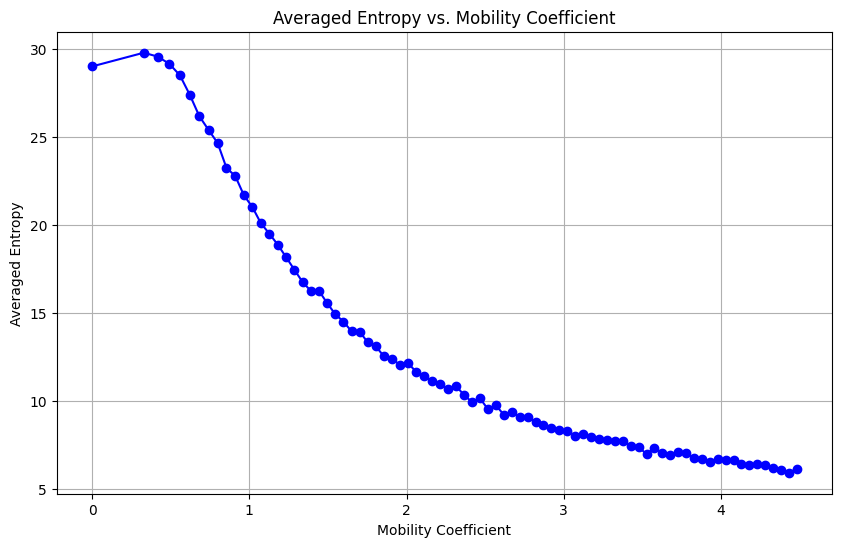

In [ ]:
import matplotlib.pyplot as plt

# Extract mobility coefficients (x-axis) and averaged entropy (y-axis)
x_values = [item[0].item() for item in table] # .item() to get scalar from CuPy array
y_values = [item[1].item() for item in table] # .item() to get scalar from CuPy array

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='blue')

# Add labels and title
plt.xlabel("Mobility Coefficient")
plt.ylabel("Averaged Entropy")
plt.title("Averaged Entropy vs. Mobility Coefficient")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Define column names for the DataFrame
column_names = ['Mobility Coefficient', 'Averaged Entropy', 'Iteration Index']

# Create a pandas DataFrame from the table
df = pd.DataFrame(table, columns=column_names)

# Convert CuPy arrays in DataFrame to scalar values if any
# This is necessary because df.to_csv() might not handle CuPy arrays directly
for col in ['Mobility Coefficient', 'Averaged Entropy']:
    df[col] = df[col].apply(lambda x: x.item() if hasattr(x, 'item') else x)

# Save the DataFrame to a CSV file
output_csv_filename = 'entropy_mobility_data.csv'
df.to_csv(output_csv_filename, index=False)

print(f"Data saved to '{output_csv_filename}'")

Data saved to 'entropy_mobility_data.csv'
